In [148]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [149]:
DEFORMATION_METHODS = ["Random", "Mirror"]
OPTIMIZER_METHODS = ["Iterative", "Annealing"]
SMOOTHING_METHODS = ["Laplacian"]

In [150]:
seeds = [0,1,2,3,4]
planes = [f"High_Vertex_Plane_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01.json" for seed in seeds]
planes_010 = [f"High_Vertex_Plane_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.10.json" for seed in seeds]
planes_025 = [f"High_Vertex_Plane_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.25.json" for seed in seeds]
planes_050 = [f"High_Vertex_Plane_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.50.json" for seed in seeds]
planes_100 = [f"High_Vertex_Plane_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json" for seed in seeds]

seeds_500k = [0]
planes_500k = [f"High_Vertex_Plane_Mirror_S{seed}-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01.json" for seed in seeds_500k]
planes_010_500k = [f"High_Vertex_Plane_Mirror_S{seed}-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.10.json" for seed in seeds_500k]
planes_025_500k = [f"High_Vertex_Plane_Mirror_S{seed}-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.25.json" for seed in seeds_500k]
planes_050_500k = [f"High_Vertex_Plane_Mirror_S{seed}-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.50.json" for seed in seeds_500k]
planes_100_500k = [f"High_Vertex_Plane_Mirror_S{seed}-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json" for seed in seeds_500k]


cubes = [f"High_Vertex_Cube_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01.json" for seed in seeds]
cubes_010 = [f"High_Vertex_Cube_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.10.json" for seed in seeds]
cubes_025 = [f"High_Vertex_Cube_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.25.json" for seed in seeds]
cubes_050 = [f"High_Vertex_Cube_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.50.json" for seed in seeds]
cubes_100 = [f"High_Vertex_Cube_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json" for seed in seeds]

spheres = [f"Sphere_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01.json" for seed in seeds]
spheres_010 = [f"Sphere_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.10.json" for seed in seeds]
spheres_025 = [f"Sphere_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.25.json" for seed in seeds]
spheres_050 = [f"Sphere_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.50.json" for seed in seeds]
spheres_100 = [f"Sphere_Mirror_S{seed}-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json" for seed in seeds]

In [151]:
def graph_json_annealing(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]

        smoothened = json_data['Smoothened']
        smoothing_method = SMOOTHING_METHODS[json_data['SmoothingMethod']] if smoothened else "None"
        smoothing_strength = json_data['SmoothingStrength']

        optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
        sampling_rate = json_data['SamplingRate']
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
        optimized_deviations = np.array(json_data['OptimizedDeviations'], dtype='float')
        
        iterations = chosen_vertices.size
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
        smooth_angular_deviation = json_data['SmoothenedAngularDeviation']
        time_ms = json_data['TimeMilliseconds']
        temps = np.array(json_data['Temperatures'], dtype=float)

        final_deviation = optimized_deviations[-1]
        opt_deviation_diff_percent = (final_deviation - deformed_deviation) / deformed_deviation * 100
        smooth_deviation_diff_percent = (smooth_angular_deviation - final_deviation) / final_deviation * 100
        total_diff_percent = (smooth_angular_deviation - deformed_deviation) / deformed_deviation * 100
        effective_iterations = np.sum(accepted_iterations)

        info = f"Plot of total angular deviation for {iterations} iterations\n"
        info += f"Object: {name}\n"
        info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)\n"
        if (deformation_method == "Random" or vertex_selection_method == "Random"):
            info += f"Seed {seed}\n"
        info += f"Deformation method: {deformation_method}\n"
        info += f"Optimizer method: {optimizer_method}\n"
        info += f"Vertex selection method: {vertex_selection_method}\n"
        info += f"Smoothing: {smoothing_method} (Strength: {np.round(smoothing_strength, 2):.2f})\n"
        info += f"{effective_iterations} iterations of total amount ({np.round(effective_iterations/iterations*100, 2):.2f}%) reduced the minimum\n"
        info += f"Time: {time_ms} ms\n"
        info += f"Total angular deviation\n"
        info += f"-- reduced by optimization from {np.round(deformed_deviation, 2):.2f} to {np.round(final_deviation, 2):.2f} ({np.round(opt_deviation_diff_percent, 2):.2f}%)\n"
        if (smoothened):
            info += f"-- changed by smoothing from {np.round(final_deviation, 2):.2f} to {np.round(smooth_angular_deviation, 2):.2f} ({np.round(smooth_deviation_diff_percent, 2):.2f}%)\n"
            info += f"+ ---------------------\n"
            info += f"Total change from {np.round(deformed_deviation, 2):.2f} to {np.round(smooth_angular_deviation, 2):.2f} ({np.round(total_diff_percent, 2):.2f}%)\n"
        print(info)

        fig= plt.figure()
        lnsOpt = plt.plot(range(iterations), current_deviations, label='Optimized TADoN')
        if (smoothened):
            lnsSm = plt.plot([0, iterations-1], [smooth_angular_deviation, smooth_angular_deviation], label="Smoothened TADoN")

        plt.xlabel("Iterations")
        plt.ylabel("TADoN (degrees)")

        ax2 = plt.twinx()
        lnsTemp = ax2.plot(range(iterations), temps, color='red', label='Temperature')
        ax2.set_ylabel("Temperature")
        
        lns = lnsOpt
        if (smoothened):
            lns += lnsSm
        lns += lnsTemp
        labels = [l.get_label() for l in lns]
        plt.legend(lns, labels)
            
        fig.tight_layout()
        fig.show()

In [152]:
def calc_averages(filenames, seeds):
    deformed_deviations = []
    final_deviations = []
    smooth_deviations = []
    durations_ms = []
    for filename in filenames:
        with open(filename) as json_file:
            json_data = json.load(json_file)
            name = json_data['ObjectName']
            vertex_count = json_data['VertexCount']
            deformed_deviation = json_data['DeformedAngularDeviation']
            deformed_deviations.append(deformed_deviation)
            deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]

            smoothened = json_data['Smoothened']
            smoothing_method = SMOOTHING_METHODS[json_data['SmoothingMethod']] if smoothened else "None"
            smoothing_strength = json_data['SmoothingStrength']

            optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
            vertex_selection_method = json_data['VertexSelectionMethod']
            chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
            accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
            optimized_deviations = np.array(json_data['OptimizedDeviations'], dtype='float')

            iterations = chosen_vertices.size
            current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
            smooth_angular_deviation = json_data['SmoothenedAngularDeviation']
            smooth_deviations.append(smooth_angular_deviation)
            time_ms = json_data['TimeMilliseconds']
            durations_ms.append(time_ms)
            temps = np.array(json_data['Temperatures'], dtype=float)

            final_deviation = optimized_deviations[-1]
            final_deviations.append(final_deviation)
            opt_deviation_diff_percent = (final_deviation - deformed_deviation) / deformed_deviation * 100
            smooth_deviation_diff_percent = (smooth_angular_deviation - final_deviation) / final_deviation * 100
            total_diff_percent = (smooth_angular_deviation - deformed_deviation) / deformed_deviation * 100
            effective_iterations = np.sum(accepted_iterations)

    info = ""
    info += f"Object: {name}\n"
    info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)\n"
    if (deformation_method == "Random" or vertex_selection_method == "Random"):
        info += f"Seeds {seeds}\n"
    info += f"Deformation method: {deformation_method}\n"
    info += f"Optimizer method: {optimizer_method}\n"
    info += f"Vertex selection method: {vertex_selection_method}\n"
    info += f"Smoothing: {smoothing_method} (Strength: {np.round(smoothing_strength, 2):.2f})\n"
    info += f"Average time taken (ms): {np.average(durations_ms):.0f}\n"
    info += f"Deformed TADoN: {np.round(np.average(deformed_deviations), 2):.2f}\n"
    info += f"Average optimized TADoN: {np.round(np.average(final_deviations), 2):.2f} ({np.round((np.average(final_deviations) - np.average(deformed_deviations))/np.average(deformed_deviations)*100, 2):.2f}% from deformed)\n"
    info += f"Average smoothed TADoN: {np.round(np.average(smooth_deviations), 2):.2f}\n"

    print(info)


In [169]:
calc_averages(spheres_100, seeds_500k)

Object: Sphere
Vertices: 515 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seeds [0]
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: Laplacian (Strength: 1.00)
Average time taken (ms): 1380971
Deformed TADoN: 6416.68
Average optimized TADoN: 3100.85 (-51.68% from deformed)
Average smoothed TADoN: 7121.54



Plot of total angular deviation for 100000 iterations
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seed 4
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: None (Strength: 0.00)
6237 iterations of total amount (6.24%) reduced the minimum
Time: 1758274 ms
Total angular deviation
-- reduced by optimization from 9666.56 to 6828.03 (-29.36%)



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_71241/1026785326.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


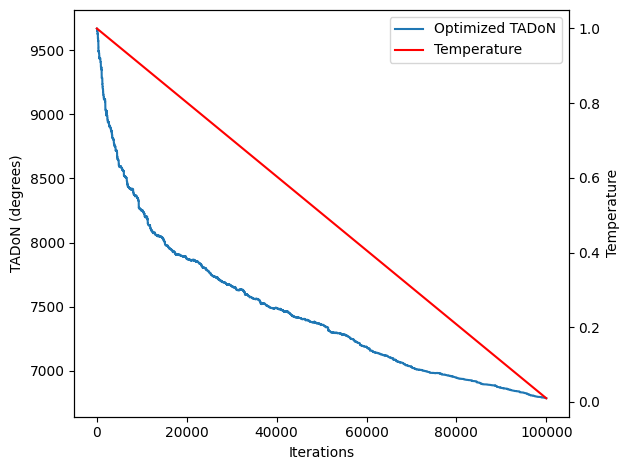

In [154]:
graph_json_annealing("High_Vertex_Plane_Mirror_S4-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01.json")

Plot of total angular deviation for 500000 iterations
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seed 0
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: Laplacian (Strength: 1.00)
24951 iterations of total amount (4.99%) reduced the minimum
Time: 8475589 ms
Total angular deviation
-- reduced by optimization from 9666.56 to 5611.88 (-41.95%)
-- changed by smoothing from 5611.88 to 9455.45 (68.49%)
+ ---------------------
Total change from 9666.56 to 9455.45 (-2.18%)



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_71241/1026785326.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


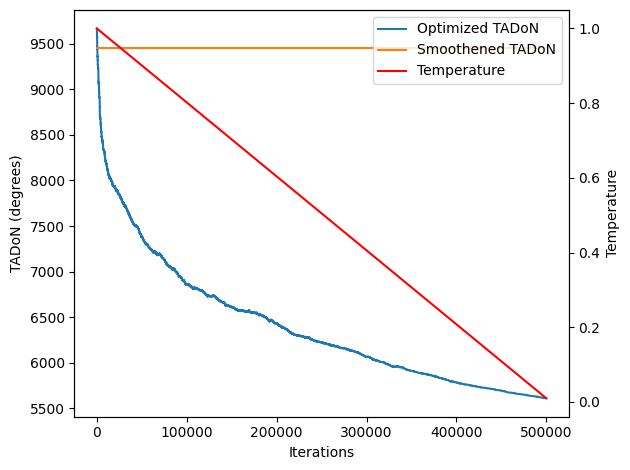

In [155]:
graph_json_annealing("High_Vertex_Plane_Mirror_S0-500000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json")

Plot of total angular deviation for 100000 iterations
Object: Sphere
Vertices: 515 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seed 0
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: Laplacian (Strength: 0.10)
8134 iterations of total amount (8.13%) reduced the minimum
Time: 1422197 ms
Total angular deviation
-- reduced by optimization from 6416.68 to 3007.92 (-53.12%)
-- changed by smoothing from 3007.92 to 3776.32 (25.55%)
+ ---------------------
Total change from 6416.68 to 3776.32 (-41.15%)



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_71241/1026785326.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


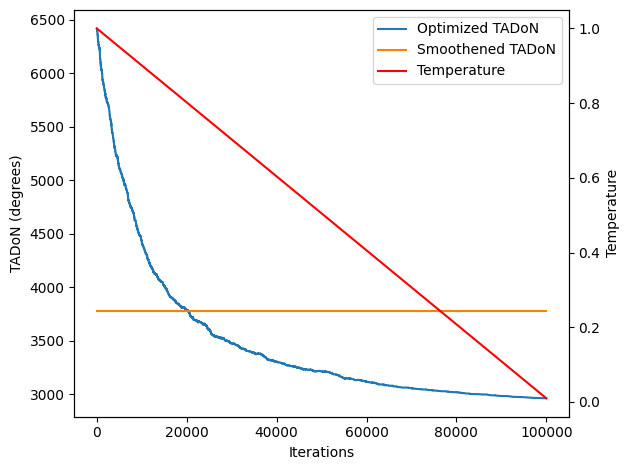

In [156]:
graph_json_annealing("Sphere_Mirror_S0-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_0.10.json")

Plot of total angular deviation for 100000 iterations
Object: High Vertex Cube
Vertices: 1734 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Seed 0
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
Smoothing: Laplacian (Strength: 1.00)
14839 iterations of total amount (14.84%) reduced the minimum
Time: 1413658 ms
Total angular deviation
-- reduced by optimization from 11270.56 to 7871.97 (-30.15%)
-- changed by smoothing from 7871.97 to 11442.18 (45.35%)
+ ---------------------
Total change from 11270.56 to 11442.18 (1.52%)



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_71241/1026785326.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


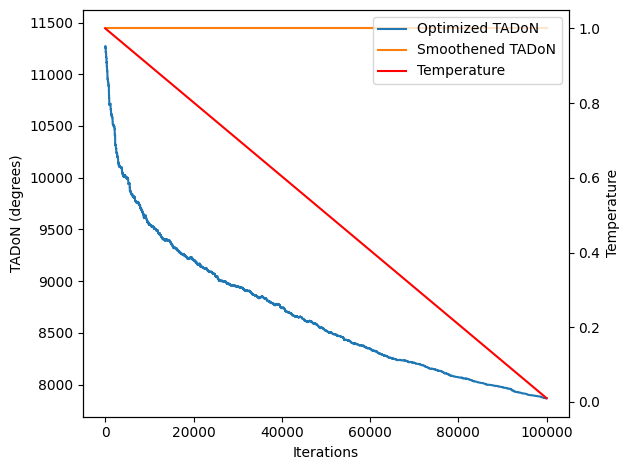

In [157]:
graph_json_annealing("High_Vertex_Cube_Mirror_S0-100000-Annealing_-0.10_to_0.10_temp_1.00_to_0.01_Laplacian_at_1.00.json")